In [1]:
import argparse
import io
import json
import os

from google.cloud import language
import numpy
import six

In [2]:
# -*- coding: utf-8 -*-
# this is a simple, commonly used text cleaning function
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [3]:
from google.cloud import language

language_client = language.LanguageServiceClient()

def classify(text, verbose=True):
    """This invokes the google named entity extractor """
    document = language.types.Document(
        content=text,
        type=language.enums.Document.Type.PLAIN_TEXT)
    response = language_client.analyze_entities(document)
    return response

import requests
import wikipedia
def findWikiData(itemurl):
    st = itemurl.find('wiki/')
    item = itemurl[st+5:]
    #print(item)
    s= "https://en.wikipedia.org/w/api.php?action=query&prop=pageprops&titles=%s&format=json"%(item)
    r = requests.get(s)
    rr =r.content.decode("utf-8")
    #print('rr=', rr)
    ans = rr.find('wikibase_item')
    answer = rr[ans+16:]
    e = answer.find('"')
    return item, answer[:e]

In [4]:
#These functions invoke the Google named entity extractor and create lists entities found 
#in the document.  
def entityExtractorBlock(sents):
    #sents = split_into_sentences(text)
    ents = []
    sentblock =  ''
    for sent in sents:
        sentblock = sentblock+' '+sent
        
    x = classify(sentblock)
    print('classifier returns:', x)
    for ent in x.entities:
        #print('--->', ent.name)
        if ent.metadata['wikipedia_url'] != '' or len(str.split(ent.name))> 1:
            wikipage = ent.metadata['wikipedia_url']
            if wikipage != '':
                name, wikidataId = findWikiData(wikipage)
                ents.append((name, wikidataId, wikipage))

            else:
                wikidataId = "none"
                #print(name, wikidataId, wikipage)
                ents.append((ent.name, wikidataId, wikipage))
        
    return ents

#The entity extractor splits the text into sentences and for each node
def entityExtractor(text, sentencespernode = 2):
    sents = split_into_sentences(text)
    l = len(sents)
    print(l)
    ents = []
    kk = 0
    for i in range(0,int(l/sentencespernode)):
        j = sentencespernode*i
        k = j + sentencespernode
        kk = k
        print(j,k)
        newents = entityExtractorBlock(sents[j:k])
        if newents != []:
            entitem = []
            for x in newents:
                entitem.append({'entity': x})
            entitem.append({'context': sents[j:k]})
            ents = ents + entitem
            #print(entitem)
    print(kk, l)
    if (kk < l):
        newents = entityExtractorBlock(sents[kk:l])
        print('newents =', newents)
        if newents != []:
            entitem = []
            for x in newents:
                entitem.append({'entity': x})
            entitem.append({'context': sents[kk:l]})
            ents = ents + entitem
            #print(entitem)
    return ents


In [5]:
## this function scrapes the wikidata page to find the instanceOf data for the given  entity
#wikiID.

import requests

def getInstanceOfId(wikiID):
    s = 'https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&languages=en&format=json'%(wikiID)
    r = requests.get(s)
    rr =r.content.decode("utf-8")
    j = json.loads(rr)
    k = rr.find('P31')
    if k > 0:
        l = rr[k:].find('"id":')
        if l > 0:
            s = rr[k+l+5:k+l+23]
            t = s.find('}')
            id = s[1:t-1]
            x = id.find('$')
            if x < 0:
                return id
            else:
                return id[:x]
        else:
            return ''
    else:
        return ''
    
def getNameFromWikiID(wikiID):
    s = 'https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&languages=en&format=json'%(wikiID)
    r = requests.get(s)
    if r.status_code == 429:
        time.sleep(8)
        r = requests.get(s)
    rr = r.content.decode("utf-8")
    s = rr.find('"value":')
    rrr= rr[s+8:s+50]
    t = rrr.find('}')
    return rrr[1:t-1] 

def getDescription(wikiId):
    s = 'https://www.wikidata.org/w/api.php?action=wbgetentities&ids=%s&languages=en&format=json'%(wikiId)
    r = requests.get(s)
    if r.status_code == 429:
      time.sleep(8)
      r = requests.get(s)

    rr =r.content.decode("utf-8")
    i = rr.find("descriptions")
    if i < 0:
        return ''
    else:
        rrr = rr[i:]
        #print(rrr)
        j = rrr.find('"value":')
        if j >0:
            #print(j)
            k = rrr.find("}")
            return(rrr[j+8: k])
        else:
            return ''


In [6]:
#  here are some samples 

In [7]:
getNameFromWikiID('Q678023')

'Late Devonian extinction'

In [8]:
getDescription('Q678023')

'"mass extinction event, starting at the end of the Frasnian age of Upper Devonian around 372 million years ago"'

In [9]:
getInstanceOfId('Q678023')

'Q55814'

In [10]:
getNameFromWikiID("Q55814")

'extinction event'

In [11]:
getDescription("Q55814")

'"widespread and rapid decrease in the amount of life on earth"'

In [12]:
import networkx as nx

In [13]:
G = nx.Graph()

In [14]:
#this is the file processing function.  Because the article nodes are given the name "ArtX" for
#an integer x we need to know what the starting x should be.   the function creates
#the graph and returns that final x value so the function can be called again.
#The main work of the function is creating the article nodes and entity nodes and adding 
#the edges.

def addFile(art_cnt, G, filename):
    items = open('../'+filename+'.txt', 'r').read().replace('\n', '')
    ents = entityExtractor(items)
    all_nodes = []
    nodes = []
    instances = []
    for e in ents:
        if e.get('entity') != None:
            #this is an entity for this node
            lab = e['entity'][2]
            name = e['entity'][0]
            wikiID = e['entity'][1]
            st = lab.find('wiki/')
            if st <0:
                item = name
                #print('Item=', item)
                G.add_node(item, flavor='entity', url='none', wikiID = 'noID', color = 'lightgreen')
                #print("just made ", G.node[item])
                G.nodes[item]['instanceof'] = []
                G.nodes[item]['subclassof'] = []
                G.nodes[item]['description'] = ''
                nodes.append(item)

            else:
                item = lab[st+5:]
                #print("item=", item)
                #wikiID = findWikiData(lab)[1]
                G.add_node(item, flavor='entity', url=lab, wikiID = wikiID, color = 'lightblue')
                #print("just smade ", item, G.nodes[item])
                instID = getInstanceOfId(wikiID)
                if instID != '':
                    inst_list = [(instID, getNameFromWikiID(instID))]
                    #print([wikiID, (instID, getNameFromWikiID(instID))])
                else:
                    inst_list = []
                clas_list = []#isASubclassOf(wikiID)
                G.nodes[item]['instanceof'] = inst_list
                instances = instances + inst_list
                G.nodes[item]['subclassof'] = clas_list        
                #classes = classes + clas_list
                G.nodes[item]['description'] = getDescription(wikiID)
                #print(findWikiData(lab))
                nodes.append(item)
        if e.get('context') != None:
            # this is a new article
            newart = 'Art'+str(art_cnt)
            G.add_node(newart, flavor='article', source=filename, context=e['context'], color='lightyellow')
            #print(newart,G.nodes[newart])
            art_cnt = art_cnt+1
            for z in nodes:
                G.add_edge(newart,z )
            all_nodes = all_nodes + nodes
            nodes = []
    instance_set = set(instances)
    instances = list(instance_set)
    print('instances ====', instances)
    #now make items for these instances
    for i in instances:
        G.add_node(i[1], flavor='entity', url='notknown', wikiID = i[0], color = 'lightgray')
        G.nodes[i[1]]['description'] = getDescription(i[0])
        G.nodes[i[1]]['instanceof'] = []
        G.nodes[i[1]]['subclassof'] = []
    #now add edges from the instance to the new entity
    all_nodes_set = set(all_nodes)
    all_nodes =  list(all_nodes_set)
    for n in all_nodes:
        if G.nodes[n]['instanceof'] != []:
            elist = G.nodes[n]['instanceof']
            for e in elist:
                G.add_edge(n, e[1])
    print(art_cnt)
    return art_cnt

In [15]:
G = nx.Graph()
art_cnt = 0
art_cnt =addFile(art_cnt, G, 'rel-short')

5
0 2
classifier returns: entities {
  name: "Theory of General Relativity"
  type: OTHER
  metadata {
    key: "mid"
    value: "/m/03538"
  }
  metadata {
    key: "wikipedia_url"
    value: "https://en.wikipedia.org/wiki/General_relativity"
  }
  salience: 0.3374597430229187
  mentions {
    text {
      content: "Theory of General Relativity"
      begin_offset: -1
    }
    type: PROPER
  }
}
entities {
  name: "Einstein"
  type: PERSON
  metadata {
    key: "mid"
    value: "/m/0jcx"
  }
  metadata {
    key: "wikipedia_url"
    value: "https://en.wikipedia.org/wiki/Albert_Einstein"
  }
  salience: 0.26492840051651
  mentions {
    text {
      content: "Einstein"
      begin_offset: -1
    }
    type: PROPER
  }
}
entities {
  name: "Black Holes"
  type: OTHER
  metadata {
    key: "mid"
    value: "/m/01h1s"
  }
  metadata {
    key: "wikipedia_url"
    value: "https://en.wikipedia.org/wiki/Black_hole"
  }
  salience: 0.08857237547636032
  mentions {
    text {
      content: "

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def showGraph(sg):
    options = {
        'node_size': 3000,
        'font_weight': 'bold',
         'edgecolors':'black',
        'width': 2,
    }
    labels = {}
    color = []
    for n in sg.nodes:
        d =sg.nodes[n]
        #print(d)
        color.append(d['color'])
        labels[n]=n
    
    #print(color)
        #print(sg.nodes[x]['url'])
        #labels[]
        
    plt.figure(3,figsize=(9,6)) 

    nx.draw(sg, labels = labels, node_color = color, **options)   

C:\Users\ganno\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


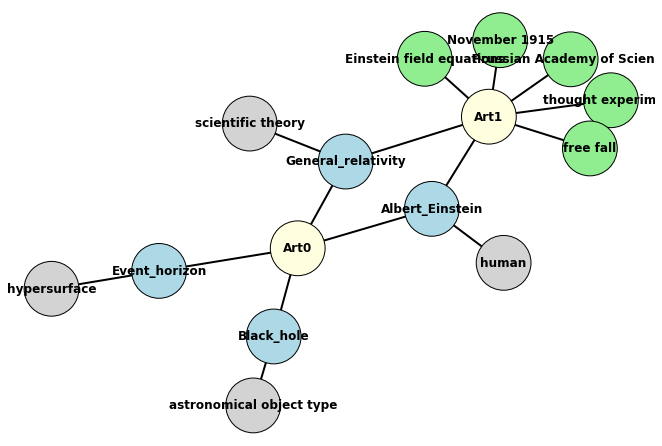

In [17]:
showGraph(G)

In [18]:
def showArticle(graph, name):
    print(name, graph.nodes[name]['context'])
    print('all edges from this node are:')
    for x in graph.edges():
        if x[1] == name:
            print(x, graph.nodes[x[0]]['url'], graph.nodes[x[0]]['wikiID'])
            

def showEntity(graph, name):
    instances = []
    classes = []
    print(name,' wikiID=', graph.nodes[name]['wikiID'], 'wikipedia url =', graph.nodes[name]['url'])
    print(graph.nodes[name]['description'])
    inst = graph.nodes[name]['instanceof'] #isAnInstanceOf(graph.nodes[name]['wikiID'])
    if inst != []:
        instances = instances +inst
        ilist = [i[1] for i in inst]
        print('is an instance of ', ilist)



In [19]:
showEntity(G, "Event_horizon")

Event_horizon  wikiID= Q181741 wikipedia url = https://en.wikipedia.org/wiki/Event_horizon
"the point of no return; boundary of a region of spacetime from which one cannot escape once entered"
is an instance of  ['hypersurface']


In [20]:
showEntity(G, "hypersurface")

hypersurface  wikiID= Q973321 wikipedia url = notknown
"generalization of the concepts of hyperplane, plane curve, and surface; a manifold or an algebraic variety of dimension n, which is embedded in an ambient space of dimension n+1"


In [21]:
showArticle(G, 'Art0')

Art0 ['The Theory of General Relativity demonstrates that Black Holes are hidden by an Event Horizon.', 'Soon after publishing the special theory of relativity in 1905, Einstein started thinking about how to incorporate gravity into his new relativistic framework.']
all edges from this node are:
('General_relativity', 'Art0') https://en.wikipedia.org/wiki/General_relativity Q11452
('Albert_Einstein', 'Art0') https://en.wikipedia.org/wiki/Albert_Einstein Q937
('Black_hole', 'Art0') https://en.wikipedia.org/wiki/Black_hole Q589
('Event_horizon', 'Art0') https://en.wikipedia.org/wiki/Event_horizon Q181741


In [22]:
showArticle(G, 'Art1')

Art1 ['In 1907, beginning with a simple thought experiment involving an observer in free fall, he embarked on what would be an eight-year search for a relativistic theory of gravity.', "After numerous detours and false starts, his work culminated in the presentation to the Prussian Academy of Science in November 1915 of what are now known as the Einstein field equations, which form the core of Einstein's famous Theory of General Relativity."]
all edges from this node are:
('General_relativity', 'Art1') https://en.wikipedia.org/wiki/General_relativity Q11452
('Albert_Einstein', 'Art1') https://en.wikipedia.org/wiki/Albert_Einstein Q937
('thought experiment', 'Art1') none noID
('free fall', 'Art1') none noID
('Einstein field equations', 'Art1') none noID
('Prussian Academy of Science', 'Art1') none noID
('November 1915', 'Art1') none noID


In [35]:
G = nx.Graph()
art_cnt = 0
art_cnt =addFile(art_cnt, G, 'late-dev-short')

4
0 2
classifier returns: entities {
  name: "ionizing radiation"
  type: OTHER
  salience: 0.3106960356235504
  mentions {
    text {
      content: "ionizing radiation"
      begin_offset: -1
    }
    type: COMMON
  }
}
entities {
  name: "causes"
  type: OTHER
  salience: 0.19708944857120514
  mentions {
    text {
      content: "causes"
      begin_offset: -1
    }
    type: COMMON
  }
}
entities {
  name: "work"
  type: OTHER
  salience: 0.16387653350830078
  mentions {
    text {
      content: "work"
      begin_offset: -1
    }
    type: COMMON
  }
}
entities {
  name: "sources"
  type: PERSON
  salience: 0.12290775030851364
  mentions {
    text {
      content: "sources"
      begin_offset: -1
    }
    type: COMMON
  }
}
entities {
  name: "extinction levels"
  type: OTHER
  salience: 0.03391239792108536
  mentions {
    text {
      content: "extinction levels"
      begin_offset: -1
    }
    type: COMMON
  }
}
entities {
  name: "Ozone depletion"
  type: OTHER
  salienc

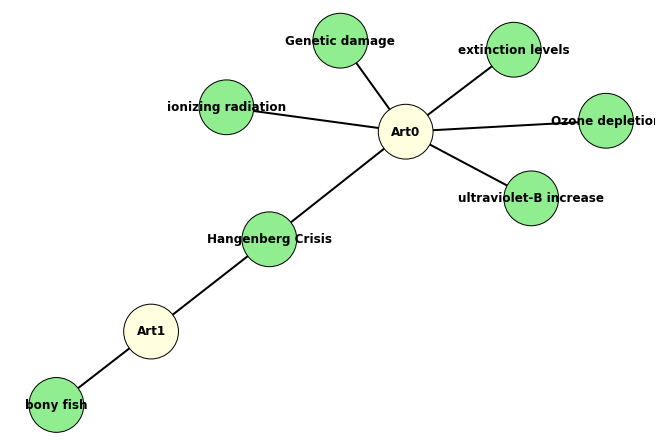

In [36]:
showGraph(G)